# Objectives

Main objectives are

- To make a list of Japanese restaurants in Zurich using Foursquare API and save it as a database using SQL.
- To visualize the locations of the restaurants on a map and show the nearest stations.
- To reveal less competitive area for opening a new Japanese restaurant.

# Motivations

1. Exploring business opportunities   
These days, Japanese food such as Sushi can be easily found in the supermarkets of Zurich even though this city is located in the middle part of Europe. This fact implies that the potential interest in Japanese cuisine has been increasing. Considering this fact, opening a new Japanese restaurant in Zurich would be a good idea. However, there are already some Japanese restaurants in Zurich. Therefore, it is important, especially for people who are interested in opening a new Japanese restaurant in Zurich, to know which area is less crowded with Japanese restaurants. 

2. Helping Japanese people living in or visinting Zurich   
People living in a foreign country often miss food in their country. The list of Japanese restaurants and their locations on a map is helpful for Japanese people who live in Zurich and miss Japanese cuisine.

# Data source

- The names and coordinates of Japanese restaurants are imported using <strong>Foursquare API</strong>.
- Based on the coordinates of the restaurants, a district, which is called "Kreis," is assigned to each restaurant. In order to assign district numbers to restaurants, the geojson data of the districts are obtained from the web page of [Open Data Katalog](https://data.stadt-zuerich.ch/dataset?sort=score+desc%2C+date_last_modified+desc&tags=geodaten&q=+Postleitzahl+zurich) provided by Zurich city.
- The list of train stations of Zurich including their coordinates is taken from [Wikipedia](https://en.wikipedia.org/wiki/Category:Railway_stations_in_Zürich).

# Data preparation

In [21]:
import numpy as np
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import os
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pandas.io.json import json_normalize 
from shapely.geometry import shape, Point
import sqlite3
from geopy.distance import great_circle
import warnings
warnings.simplefilter('ignore')

## Coordinate of Zurich main station

At first, the following information will be specified:
- the number of districts in Zurich. These districts are called "Kreis."
- the coordinate of the Zurich main station, which is called Zurich Hauptbahnhof and often abbreviated as Zurich HB.

The number number of districts is 12 (24/02/2019)

In [3]:
#number of districts (Kreis)
num_kreis=12

The coordinate of the Zurich HB will be obtained using Google API. A function for getting a coordinate of a specific place is defined in the next cell.

In [4]:
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]

In the next cell, you have to use your own Google API key. If you do not have it yet, you can simply run the following command:  
`latitude_ZHB, longitude_ZHB = 47.3778669, 8.5403453`

In [5]:
google_api_key='yourGoogleAPIkey'
address='Zurich main station'
  
coord_place = get_coordinates(google_api_key, address)
latitude_ZHB=coord_place[0]
longitude_ZHB=coord_place[1]

print('The coordinates are {}, {}'.format(latitude_ZHB,longitude_ZHB))
# expected coordinates: 47.3778669, 8.5403453

The coordinates are 47.3778669, 8.5403453


We will see if the obtained coordinate is correct. If the coordinate is correct, a red round marker will appear on the center of the Zurich HB with a popup of "Zurich Hauptbahnhof."

In [6]:
map_Zurich = folium.Map(location=[latitude_ZHB, longitude_ZHB], zoom_start=17) # generate map centred around the Hauptbahnhof

folium.CircleMarker(
        [latitude_ZHB, longitude_ZHB],
        radius=8,
        color='red',
        fill = True,
        fill_color='red',
        popup='Zurich Hauptbahnhof',
        fill_opacity=0.6
    ).add_to(map_Zurich)

map_Zurich

If you succeeded in running the above cell, you can get a map shown below:
<img src="https://i.imgur.com/iHfkmdb.png" width="500px">    

## Information of Japanese restaurant

As a next step, information about Japanese restaurants in Zurich will be obtained using <strong>Foursquare API</strong>. In order to use Foursquare, the client ID, client secret, and version should be specified.

In [7]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = 'Foursquare API version' # Foursquare API version

URL including information about Japanese restaurants in Zurich will be created by using Foursquare. The word "Japanese" will be used for the search query. The limit number of Japanese restaurants returned by Foursquare API will be set as 100. The radius from the Zurich HB will be set to be 10 km. This radius is large enough to cover all districts of Zurich.

In [8]:
search_query = 'Japanese'

LIMIT = 100 # limit of number of Japanese restaurants returned by Foursquare API
radius = 10000 # define radius. This radius should be large enough to cover all districts of Zurich.
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_ZHB, 
    longitude_ZHB,
    search_query,
    radius, 
    LIMIT)

results = requests.get(url).json()

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

A dataframe including the names of restaurants and the coordinates will be created in the next cell.

In [23]:
venues = results['response']['groups'][0]['items']
Restaurant = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.neighborhood', 'venue.location.lat', 'venue.location.lng']
Restaurant =Restaurant.loc[:, filtered_columns]

# filter the category for each row
Restaurant['venue.categories'] = Restaurant.apply(get_category_type, axis=1)

# clean columns
Restaurant.columns = [col.split(".")[-1] for col in Restaurant.columns]

Restaurant.head()

,name,categories,neighborhood,lat,lng
0,Kokoro,Japanese Restaurant,Kreis 4,47.380680,8.526546
1,Japan-Restaurant Bimi,Japanese Restaurant,NaN,47.363665,8.549325
2,Ikoo,Japanese Restaurant,Kreis 4,47.375044,8.528807
3,Miki Ramen,Japanese Restaurant,NaN,47.375152,8.516653
4,Samurai,Japanese Restaurant,NaN,47.373747,8.527697


In [24]:
num_restaurant=Restaurant.shape[0]
print('{} restaurants were returned by Foursquare.'.format(num_restaurant))

56 restaurants were returned by Foursquare.


The name of the column "neighborhood" will be changed to "Kreis." This column will be used to show which district the restaurant belongs to.

In [25]:
# Change the name of the column
Restaurant = Restaurant.rename(columns={'neighborhood': 'Kreis'})

## Defining the boundaries of Zurich city and districts (Kreis)

Since we would like to assign districts (Kreis) to the obtained restaurants, we need to get the geographic information about the boundaries of the districts. The geojson data for showing districts in Zurich was obtained [here](https://data.stadt-zuerich.ch/dataset/5fd779b6-64b3-4320-baa2-40e4de59dfc6/resource/261666ee-2ca0-43cb-927c-0f610e96cea1/download/stadtkreise.json)

In [26]:
currentdir=os.getcwd()
datapath=currentdir+'/kreis.geojson'
#https://data.stadt-zuerich.ch/dataset/5fd779b6-64b3-4320-baa2-40e4de59dfc6/resource/261666ee-2ca0-43cb-927c-0f610e96cea1/download/stadtkreise.json
f=open(datapath)
json_data=json.load(f)

A function for visualizing boundaries is defined.

In [27]:
def boundary(base_map, geojson_path):
    base_map.choropleth(geo_data=geojson_path, 
                        line_color="black", 
                        line_weight=3, 
                        fill_color='white', 
                        fill_opacity=0.1, 
                        line_opacity=0.5)

A map of Zurich with boundary lines of districts is shown.

In [28]:
# Map of Zurich using latitude and longitude values
map_Zurich = folium.Map(location=[latitude_ZHB, longitude_ZHB], zoom_start=11) # generate map centred around the Hauptbahnhof
boundary(base_map=map_Zurich, geojson_path=json_data)
map_Zurich

If you run the cell above, you can get a map like this:  
<img src="https://i.imgur.com/EWzOUt8.png" width="500px">    

Now, the boundaries of the districts are defined correctly.  

## Assigning Kreis numbers to restaurants

As a next step, two modifications will be made for the dataframe.
- A district (Kreis) number will be assigned to each restaurant based on the coordinate of the restaurant. If the coordinate of the restaurant is out of Zurich city, the corresponding data will be discarded. 
- For some reasons, a few Chinese restaurants are also included in the data frame. They will be omitted from the data frame. 

In [29]:
# Define a function for showing which districts the coordinate (lat and lon) belongs to. 
def belong(geo_json, lat, lon):
    point = Point(lon, lat)
    for feature in geo_json['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['kname'] 
    return None

In [30]:
#Assign district (Kreis)
num_omit=1
for j in np.linspace(0,num_restaurant-1,num_restaurant):
    lat=Restaurant['lat'][j]
    lon=Restaurant['lng'][j]

    Assignment_Kreis = belong(json_data, lat, lon)
    
    if Assignment_Kreis==None:
        if num_omit==1:
            omitrows=[j]
            num_omit=2
        else:
            omitrows.append(j)
    else:
        Assignment_Kreis=Assignment_Kreis.strip('Kreis ')

        Restaurant['Kreis'][j]=int(Assignment_Kreis)

    if Restaurant['categories'][j]=='Chinese Restaurant':
        if num_omit==1:
            omitrows=[j]
            num_omit=2
        else:
            omitrows.append(j)
            

# Omit rows with "None" and/or "Chinese restaurant"
omitrows=[int(nn) for nn in omitrows]
Restaurant.drop(omitrows, axis=0,inplace=True)

#sort data based on the Kreis
Restaurant.sort_values('Kreis',inplace=True)

#reset index
Restaurant.reset_index(inplace=True,drop=True)

Restaurant

,name,categories,Kreis,lat,lng
0,Re Place Iko Miki,Ramen Restaurant,1,47.370627,8.549584
1,Maki Haus,Japanese Restaurant,1,47.378189,8.543791
2,Sushishop,Sushi Restaurant,1,47.372857,8.535131
3,Yooji's,Sushi Restaurant,1,47.367173,8.546464
4,O'Tabe,Japanese Restaurant,1,47.368881,8.538315
5,Barfüsser,Sushi Restaurant,1,47.373601,8.544591
6,Sora Sushi,Sushi Restaurant,1,47.377623,8.539133
7,Negishi Sushi Bar,Japanese Restaurant,1,47.370853,8.543192
8,Isakaya,Japanese Restaurant,1,47.376640,8.540564
9,Sala Of Tokyo,Japanese Restaurant,1,47.376185,8.540322


In [31]:
print('{} restaurants in Zurich were found by Foursquare.'.format(Restaurant.shape[0]))

49 restaurants in Zurich were found by Foursquare.


The number of Japanese restaurants is summarized for each district.

In [32]:
Restaurant['Kreis'].value_counts().index

df_kreis_restaurant=pd.DataFrame({ 'Kreis' : Restaurant['Kreis'].value_counts().index,
                                  'Number of restaurants' : Restaurant['Kreis'].value_counts().values})

l1=Restaurant['Kreis'].value_counts().index 
l2=[j for j in range(1,num_kreis+1)]
diff_list=list(set(l2) - set(l1))

if len(diff_list) != 0:
    l3 = [0]*len(diff_list)
    df_temp=pd.DataFrame({ 'Kreis' :diff_list, 'Number of restaurants': l3})
    df_kreis_restaurant=df_kreis_restaurant.append(df_temp).copy()
        

df_kreis_restaurant.sort_values('Kreis',inplace=True)
df_kreis_restaurant.reset_index(drop=True, inplace=True)

df_kreis_restaurant

,Kreis,Number of restaurants
0,1,19
1,2,3
2,3,3
3,4,8
4,5,6
5,6,1
6,7,0
7,8,4
8,9,1
9,10,1


## Coordinates of train stations in Zurich

In [33]:
currentdir=os.getcwd()
datapath=currentdir+'/stations.kml'
myfile= open(datapath, 'r', encoding="utf-8")
coord_stations = myfile.readlines() 
myfile.close()

print(coord_stations)

['<?xml version="1.0" encoding="UTF-8"?>\n', '<kml xmlns="http://earth.google.com/kml/2.1">\n', '<Document>\n', '\t<name><![CDATA[Category:Railway stations in Zürich]]></name>\n', '\t<open>1</open>\n', '\t\t<Placemark>\n', '\t\t\t<name><![CDATA[Stettbach railway station]]></name>\n', '\t\t\t<Point>\n', '\t\t\t\t<coordinates>8.5961,47.3972,0</coordinates>\n', '\t\t\t</Point>\n', '\t\t\t<Snippet></Snippet>\n', '\t\t\t<description><![CDATA[<br>Source: Wikipedia article <a href="https://en.wikipedia.org/wiki/Stettbach_railway_station">Stettbach railway station</a>]]></description>\n', '\t\t</Placemark>\n', '\t\t<Placemark>\n', '\t\t\t<name><![CDATA[Zürich Affoltern railway station]]></name>\n', '\t\t\t<Point>\n', '\t\t\t\t<coordinates>8.508241,47.421014,0</coordinates>\n', '\t\t\t</Point>\n', '\t\t\t<Snippet></Snippet>\n', '\t\t\t<description><![CDATA[<br>Source: Wikipedia article <a href="https://en.wikipedia.org/wiki/Zürich_Affoltern_railway_station">Zürich Affoltern railway station</a>]

In [34]:
print('The obtained list consists of {} rows.'.format(len(coord_stations)))

The obtained list consists of 207 rows.


A new dataframe including the name of stations, their districts, and coordinates will be created.

In [35]:
station_list=[]
station_lon=[]
station_lat=[]
Assignment_Kreis_stations=[]

for j in range(0,len(coord_stations),1):
    if (('<name><![CDATA[' in coord_stations[j])== True) and (5<j) and (j<len(coord_stations)-2):
        station_list.append(coord_stations[j][coord_stations[j].index('CDATA')+6:coord_stations[j].index(']]></name>')])
        
        lat=float(coord_stations[j+2][coord_stations[j+2].index(',')+1:coord_stations[j+2].index('</coordinates>')-2])
        lon=float(coord_stations[j+2][coord_stations[j+2].index('<coordinates>')+13:coord_stations[j+2].index(',')])
        station_lon.append(lon)
        station_lat.append(lat)
        Assignment_Kreis_stations.append(int(belong(json_data, lat, lon).strip('Kreis ')))
               
cols = ['station','Kreis','latitude','longitude']
df_stations = pd.DataFrame(index=[], columns=cols)
df_stations['station']=station_list
df_stations['Kreis']=Assignment_Kreis_stations
df_stations['latitude']=station_lat
df_stations['longitude']=station_lon


#sort data based on the Kreis
df_stations.sort_values('Kreis',inplace=True)

#reset index
df_stations.reset_index(inplace=True,drop=True)

df_stations

,station,Kreis,latitude,longitude
0,Zürich Stadelhofen railway station,1,47.366667,8.548611
1,Zürich Hauptbahnhof,1,47.377778,8.540278
2,Zürich Manegg railway station,2,47.338216,8.519881
3,Zürich Leimbach railway station,2,47.333600,8.519100
4,Zürich Enge railway station,2,47.365278,8.531944
5,Zürich Wollishofen railway station,2,47.347800,8.533800
6,Zürich Brunau railway station,2,47.351952,8.526496
7,Zürich Friesenberg railway station,3,47.364700,8.508000
8,Zürich Wiedikon railway station,3,47.371400,8.523600
9,Zürich Triemli railway station,3,47.365000,8.495200


The number of stations will be added to the dataframe "df_kreis_restaurant" including the number of restaurants.

In [37]:
num_station=[]
for j1 in range(1,num_kreis+1,1):
    if (j1 in df_stations['Kreis'].value_counts().index)==True:
        num_station.append(df_stations['Kreis'].value_counts()[j1])
    else:
        num_station.append(0)

df_kreis_restaurant['Number of stations']=num_station

df_kreis_restaurant

,Kreis,Number of restaurants,Number of stations
0,1,19,2
1,2,3,5
2,3,3,7
3,4,8,2
4,5,6,0
5,6,1,0
6,7,0,0
7,8,4,2
8,9,1,1
9,10,1,2


## Searching the nearest station from the restaurant

The [great circle distance](https://en.wikipedia.org/wiki/Great-circle_distance) is adopted as the distance between two coordinates.

In [41]:
Restaurant['nearest_station']=np.zeros(Restaurant.shape[0],dtype=np.int8)
Restaurant['station_label']=np.zeros(Restaurant.shape[0],dtype=np.int8)
Restaurant['distance']=np.zeros(Restaurant.shape[0])

for i in range(Restaurant.shape[0]):
    dist_min=1e15 # arbitrary large number  
    idx_station=0
    
    lat_restaurant, lon_restaurant = Restaurant.iloc[i,[3,4]]

    for j in range(df_stations.shape[0]):
        lat_station, lon_station = df_stations.iloc[j,[2,3]]
        
        dist=great_circle( ( lat_restaurant, lon_restaurant) , (lat_station, lon_station)).kilometers
        
        if dist < dist_min:
            dist_min = dist
            idx_nearest_station=j
    
    Restaurant.iloc[i,5]=df_stations['station'][idx_nearest_station]
    Restaurant.iloc[i,6]=idx_nearest_station
    Restaurant.iloc[i,7]=dist_min

Restaurant.head()

,name,categories,Kreis,lat,lng,nearest_station,station_label,distance
0,Re Place Iko Miki,Ramen Restaurant,1,47.370627,8.549584,Zürich Stadelhofen railway station,0,0.446423
1,Maki Haus,Japanese Restaurant,1,47.378189,8.543791,Zürich Hauptbahnhof,1,0.268422
2,Sushishop,Sushi Restaurant,1,47.372857,8.535131,Zürich Selnau railway station,14,0.228324
3,Yooji's,Sushi Restaurant,1,47.367173,8.546464,Zürich Stadelhofen railway station,0,0.171238
4,O'Tabe,Japanese Restaurant,1,47.368881,8.538315,Zürich Enge railway station,4,0.625060


# Saving data

Let us save data as a database.

In [38]:
# make a new folder if it does not exist.
output_path= os.getcwd() + '/output'

if not os.path.exists('output'):
    os.mkdir(output_path)

# save data as a database using SQLite
common_path = os.getcwd()
datpath = common_path + "/output/japanese_restaurant.db"

conn = sqlite3.connect(datpath) # establish a conenction to the SQLite database from python
cur = conn.cursor() # get a cursor object from the connection object

# Create tables 
Restaurant.to_sql('japanese_restaurant', conn, if_exists='replace')
df_stations.to_sql('station_in_zurich', conn, if_exists='replace')
df_kreis_restaurant.to_sql('summary', conn, if_exists='replace')
    
# Save (commit) the changes
conn.commit()

# close
conn.close()

# Data Analysis

## Choropleth map

The obtained data will be shown as a choropleth map. In the map, the position of the Japanese restaurants and stations in Zurich are also shown by blue and black circles, respectively.

In [39]:
map_Zurich = folium.Map(location=[latitude_ZHB, longitude_ZHB], zoom_start=12) # generate map centred around the Hauptbahnhof

# generate choropleth map
map_Zurich.choropleth(
    geo_data=json_data,
    data=df_kreis_restaurant,
    columns=['Kreis','Number of restaurants'],
    key_on='feature.properties.knr',
    fill_color='YlOrRd', 
#    threshold_scale=[0.0,1.0,2.0,3.0,12.0],
    fill_opacity=0.5, 
    line_opacity=0.6,
    legend_name='Number of Japanese restaurants'
)

for lat, lng, label in zip(Restaurant.lat, Restaurant.lng, Restaurant.name):
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6,
    ).add_to(map_Zurich)
    
for lat, lng, label in zip(df_stations.latitude, df_stations.longitude, df_stations.station):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='black',
        popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=0.5
    ).add_to(map_Zurich)

# display map
map_Zurich

If you run the cell above, you can get the map shown below:  
<img src="https://i.imgur.com/Xmr1ApA.png" width="500px"> 

This map is an interactive map. Hence, if you click a circle, you will see the name of the restaurant or the station.  
<img src="https://i.imgur.com/437LaPi.png" width="500px">
<img src="https://i.imgur.com/8xj7wnx.png" width="500px">



As you can see, the central part (Kreis 1) is a very competitive area. This district is the one where the Zurich main station exist.

## Choropleth map for clustered data

The map shown above is fine. However, it is also possible to specify which one is the nearest station from restaurants. 

In [42]:
near_station_lits=Restaurant['nearest_station'].value_counts().index.tolist()

color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 
              'beige', 'cadetblue', 'white', 
              'pink', 'lightblue', 'lightgreen', 'gray',  'lightgray'
             ] 

map_Zurich = folium.Map(location=[latitude_ZHB, longitude_ZHB], zoom_start=12) # generate map centred around the Hauptbahnhof

# generate choropleth map 
map_Zurich.choropleth(
    geo_data=json_data,
    data=df_kreis_restaurant,
    columns=['Kreis','Number of restaurants'],
    key_on='feature.properties.knr',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.6,
    legend_name='Number of Japanese restaurants'
)

for lat, lng, res_name , station_name in zip(Restaurant.lat, Restaurant.lng, Restaurant.name, Restaurant.nearest_station):
    folium.CircleMarker(
        [lat, lng],
        radius = 2,
        color = color_list[near_station_lits.index(station_name)],
        popup = res_name,
        fill = True,
        fill_color = color_list[near_station_lits.index(station_name)],
        fill_opacity=1,
    ).add_to(map_Zurich)

for lat, lng, station_name in zip(df_stations.latitude, df_stations.longitude, df_stations.station):
    if station_name not in near_station_lits:
        c='black'
    else:
        c=color_list[near_station_lits.index(station_name)]

    folium.CircleMarker(
        [lat, lng],
        radius=4,
        color='black',
        popup=station_name,
        fill = True,
        fill_color=c,
        fill_opacity=1
    ).add_to(map_Zurich)

# display map
map_Zurich

<img src="https://i.imgur.com/nvfweRs.png" width="500px">

## Another data visualization

Next, the number of stations and Japanese restaurants will be shown as bar graphs.

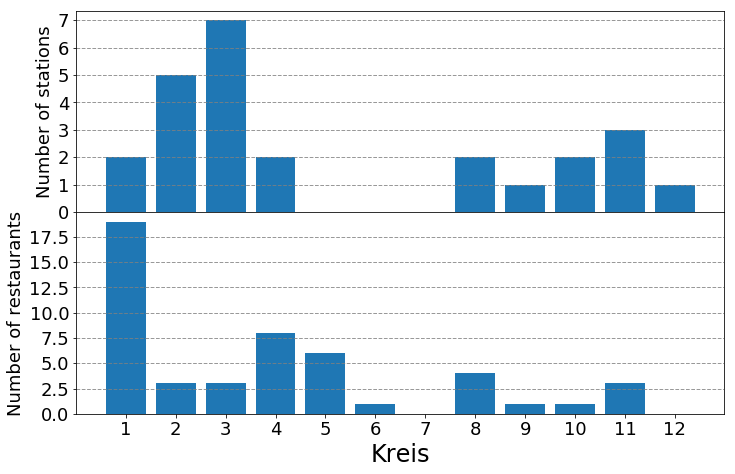

In [44]:
fig = plt.figure()

ax1 = fig.add_axes((0, 0.7, 1.5, 0.7))
ax2 = fig.add_axes((0, 0, 1.5, 0.7), sharex=ax1)

ax1.tick_params(labelbottom="off")
ax2.set_xticks(np.arange(1,13,1))
ax2.set_xlabel('Kreis',fontsize=24)
ax1.set_ylabel('Number of stations',fontsize=18)
ax2.set_ylabel('Number of restaurants',fontsize=18)

for tick in ax2.xaxis.get_ticklabels():
    tick.set_fontsize(18)
for tick in ax2.yaxis.get_ticklabels():
    tick.set_fontsize(18)
for tick in ax1.yaxis.get_ticklabels():
    tick.set_fontsize(18)
    
ax1.grid(which = "major", axis = "y", color = "grey", alpha = 0.8,linestyle = "--", linewidth = 1)
ax2.grid(which = "major", axis = "y", color = "grey", alpha = 0.8,linestyle = "--", linewidth = 1)

ax1.bar(np.linspace(1,12,12), df_kreis_restaurant['Number of stations'])
ax2.bar(np.linspace(1,12,12), df_kreis_restaurant['Number of restaurants'])
None

There are some notable features:  
- The numbe rof Japanese restaurants in Kreis 1 is large even though there are only 2 stations. However, it should be noted that there is the Zurich main station in this district.
- In Kreis 7, there are relatively many train stations. Compared to the number of stations, that of the Japanese restaurants is relatively small.
- There are no train stations in Kreis 5, 6, and 7.
- There are no Japanese restaurants in Kreis 7 and 12.